### Imports

In [2]:
%pip install yfinance
%pip install matplotlib
%pip install scikit-learn
%pip install lxml

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 92.1 MB/s  0:00:00
  Created wheel for multitasking: filename=multitasking-0.0.12-py3-none-any.whl size=15636 sha256=c272803020a03dd379e412b633e5c29bfbf6e56b407cb1ad235429fcd3f39719
  Stored in directory: /home/onyxia/.cache/pip/wheels/1e/df/0f/e2bbb22d689b30c681feb5410ab64a2523437b34c8ecfc6476
Successfully built multitasking
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6/6 [yfinance]5/6 [yfinance]]
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 83.8 MB/s  0:00:00
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
import pickle
import requests
import copy
import yfinance as yf
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats.mstats import winsorize
from sklearn.linear_model import LinearRegression

## Data collection

In [2]:
url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36"
}
html = requests.get(url, headers=headers)
SPY_tickers = pd.read_html(html.text)[0]['Symbol'].tolist()
SPY_tickers.append("^GSPC")

/tmp/ipykernel_101784/801941168.py:6: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  SPY_tickers = pd.read_html(html.text)[0]['Symbol'].tolist()


In [ ]:
data = yf.download(SPY_tickers, start="2000-01-01", end="2025-11-25", auto_adjust=True)

[                       0%                       ]  2 of 502 completed$BF.B: possibly delisted; no price data found  (1d 2000-01-01 -> 2025-11-25)
[*********             18%                       ]  90 of 502 completed

In [5]:
data.to_parquet("data/SPY_data.pq")

## Dataset creation

In [4]:
data = pd.read_parquet("data/SPY_data.pq")

In [3]:
# selected_stocks = data['Close'].columns.unique()[(data['Close'].isna().mean()<0.1)]

In [4]:
# len(selected_stocks)

In [5]:
data.columns.get_level_values(0).unique()

Index(['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume'], dtype='object', name='Price')

In [6]:
log_close = np.log(data['Close'])
log_open  = np.log(data['Open'])
log_high  = np.log(data['High'])
log_low   = np.log(data['Low'])

stocks = data['Close'].columns.unique()[:-1]
# stocks = selected_stocks[:-1]
index = '^GSPC'

# --- returns ---
close_diff = log_close[stocks].diff()
index_ret  = log_close[index].diff()

df = close_diff.mul(1e4).stack().rename("close_1d_ret").reset_index()

df["close_1d_ret_hedged"] = (
    (close_diff.sub(index_ret, axis=0) * 1e4)
    .stack()
    .values
)

# --- open-close ---
open_close = (log_close[stocks] - log_open[stocks]) * 1e4
open_close_idx = (log_close[index] - log_open[index]) * 1e4

df = df.merge(
    open_close.stack().rename("open_close_ret").reset_index(),
    on=["Date", "Ticker"]
)

df = df.merge(
    (open_close.sub(open_close_idx, axis=0))
        .stack()
        .rename("open_close_ret_hedged")
        .reset_index(),
    on=["Date", "Ticker"]
)

# --- close-open ---

close_open = (log_open[stocks] - log_close[stocks].shift()) * 1e4
close_open_idx = (log_open[index] - log_close[index].shift()) * 1e4

df = df.merge(
    close_open.stack().rename("close_open_ret").reset_index(),
    on=["Date", "Ticker"]
)

df = df.merge(
    (close_open.sub(close_open_idx, axis=0))
        .stack()
        .rename("close_open_ret_hedged")
        .reset_index(),
    on=["Date", "Ticker"]
)

# --- high-low ---
high_low = (log_high[stocks] - log_low[stocks]) * 1e4
high_low_idx = (log_high[index] - log_low[index]) * 1e4

df = df.merge(
    high_low.stack().rename("high_low_ret").reset_index(),
    on=["Date", "Ticker"]
)

df = df.merge(
    (high_low.sub(high_low_idx, axis=0))
        .stack()
        .rename("high_low_ret_hedged")
        .reset_index(),
    on=["Date", "Ticker"]
)

# --- volumes ---
volume = data['Volume'][stocks]
dollar_volume = volume * (data['Open'][stocks] + data['Close'][stocks])/2
dolar_volume_share = volume.div(volume.sum(axis=1), axis=0)

df = df.merge(
    volume.stack().rename("volume").reset_index(),
    on=["Date", "Ticker"]
)

df = df.merge(
    dollar_volume.stack().rename("dollar_volume").reset_index(),
    on=["Date", "Ticker"]
)

df = df.merge(
    dolar_volume_share.stack().rename("share_dollar_volume").reset_index(),
    on=["Date", "Ticker"]
)

In [7]:
df['body_ratio'] = df['open_close_ret'] / (df['high_low_ret']+1e-8)

In [8]:
df['turnover_proxy'] = df['dollar_volume'] / df.groupby('Date')['dollar_volume'].transform('mean')

In [9]:
df.set_index('Date', inplace=True)

In [10]:
df['close_1d_ret_lag1'] = df.groupby('Ticker')['close_1d_ret'].shift()
df['close_1d_ret_hedged_lag1'] = df.groupby('Ticker')['close_1d_ret_hedged'].shift()
df['open_close_ret'] = df.groupby('Ticker')['open_close_ret'].shift()
df['open_close_ret_hedged'] = df.groupby('Ticker')['open_close_ret_hedged'].shift()
df['close_open_ret'] = df.groupby('Ticker')['close_open_ret'].shift()
df['close_open_ret_hedged'] = df.groupby('Ticker')['close_open_ret_hedged'].shift()
df['high_low_ret'] = df.groupby('Ticker')['high_low_ret'].shift()
df['high_low_ret_hedged'] = df.groupby('Ticker')['high_low_ret_hedged'].shift()
df['share_dollar_volume'] = df.groupby('Ticker')['share_dollar_volume'].shift()
df['body_ratio'] = df.groupby('Ticker')['body_ratio'].shift()
df['turnover_proxy'] = df.groupby('Ticker')['turnover_proxy'].shift()

In [11]:
df.tail()

,Ticker,close_1d_ret,close_1d_ret_hedged,open_close_ret,open_close_ret_hedged,close_open_ret,close_open_ret_hedged,high_low_ret,high_low_ret_hedged,volume,dollar_volume,share_dollar_volume,body_ratio,turnover_proxy,close_1d_ret_lag1,close_1d_ret_hedged_lag1
Date,,,,,,,,,,,,,,,,
2025-11-24,XYZ,-14.538433,-168.026622,-102.779030,-174.549343,102.779030,76.798313,551.886861,342.305225,7393600.0,4.579411e+08,0.003227,-0.186232,0.735774,0.000000,-97.751030
2025-11-24,YUM,-124.977450,-278.465639,205.389469,133.619155,44.135145,18.154428,232.154747,22.573111,3656900.0,5.535747e+08,0.000610,0.884709,0.336630,249.524614,151.773584
2025-11-24,ZBH,144.320907,-9.167282,297.280165,225.509851,45.926001,19.945284,398.187759,188.606124,2779100.0,2.594290e+08,0.000631,0.746583,0.209783,343.206166,245.455135
2025-11-24,ZBRA,62.060605,-91.427584,370.765291,298.994977,164.144503,138.163786,552.874732,343.293096,930100.0,2.251958e+08,0.000282,0.670614,0.244384,534.909794,437.158763
2025-11-24,ZTS,66.142011,-87.346178,476.520315,404.750001,42.192155,16.211439,533.773332,324.191696,7826900.0,9.568385e+08,0.001575,0.892739,0.687740,518.712470,420.961440


In [12]:
linear_features = ['close_1d_ret_lag1', 'close_1d_ret_hedged_lag1', 'open_close_ret', 'open_close_ret_hedged', 'close_open_ret', 'close_open_ret_hedged', 'high_low_ret', 'high_low_ret_hedged', 'body_ratio']
non_linear_features = ['share_dollar_volume', 'turnover_proxy']

In [13]:
df

,Ticker,close_1d_ret,close_1d_ret_hedged,open_close_ret,open_close_ret_hedged,close_open_ret,close_open_ret_hedged,high_low_ret,high_low_ret_hedged,volume,dollar_volume,share_dollar_volume,body_ratio,turnover_proxy,close_1d_ret_lag1,close_1d_ret_hedged_lag1
Date,,,,,,,,,,,,,,,,
2000-01-04,A,-794.643144,-403.651390,NaN,NaN,NaN,NaN,NaN,NaN,4765083.0,1.920636e+08,NaN,NaN,NaN,NaN,NaN
2000-01-04,AAPL,-880.772906,-489.781152,NaN,NaN,NaN,NaN,NaN,NaN,512377600.0,4.048176e+08,NaN,NaN,NaN,NaN,NaN
2000-01-04,ABT,-289.878800,101.112954,NaN,NaN,NaN,NaN,NaN,NaN,10734887.0,8.536905e+07,NaN,NaN,NaN,NaN,NaN
2000-01-04,ACGL,-54.500128,336.491626,NaN,NaN,NaN,NaN,NaN,NaN,84600.0,1.019541e+05,NaN,NaN,NaN,NaN,NaN
2000-01-04,ADBE,-876.182492,-485.190739,NaN,NaN,NaN,NaN,NaN,NaN,7813200.0,1.193387e+08,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-11-24,XYZ,-14.538433,-168.026622,-102.779030,-174.549343,102.779030,76.798313,551.886861,342.305225,7393600.0,4.579411e+08,0.003227,-0.186232,0.735774,0.000000,-97.751030
2025-11-24,YUM,-124.977450,-278.465639,205.389469,133.619155,44.135145,18.154428,232.154747,22.573111,3656900.0,5.535747e+08,0.000610,0.884709,0.336630,249.524614,151.773584
2025-11-24,ZBH,144.320907,-9.167282,297.280165,225.509851,45.926001,19.945284,398.187759,188.606124,2779100.0,2.594290e+08,0.000631,0.746583,0.209783,343.206166,245.455135


In [14]:
df.to_parquet('df_base.pq')

# Feature list
1. Avg past returns close to close
2. Avg past returns open to close
3. Avg past returns low to close
4. Avg past returns high to low

- Hedged/Not hedged
- Clipped/Not clipped

# Models list

## Baseline
1. Random
2. Past returns (define period)
3. MACD vol adjusted
4. Linear Regression (define features + beta)

## LTR
1. LambdaMART (pairwise)
2. LambdaRANK (listwise)
3. ListMLE (listwise - use LightGBM)

# Baseline models

## Random Strategy

In [15]:
df = pd.read_parquet('df_base.pq')

In [16]:
np.random.seed(42)
df['random_signal'] = 0.0

def assign_random_signals(group):
    n = len(group)
    if n >= 70:
        signals = np.array([1.0] * 35 + [-1.0] * 35 + [0.0] * (n - 70))
        np.random.shuffle(signals)
        return pd.Series(signals, index=group.index)
    else:
        return pd.Series(0.0, index=group.index)

df['random_signal'] = df.groupby('Date', group_keys=False).apply(assign_random_signals)

In [17]:
random_daily_returns = df.groupby('Date').apply(lambda x: (x['random_signal']*x['close_1d_ret']).sum()/70)

<Axes: title={'center': 'Cumulative Random Strategy Return'}, xlabel='Date'>

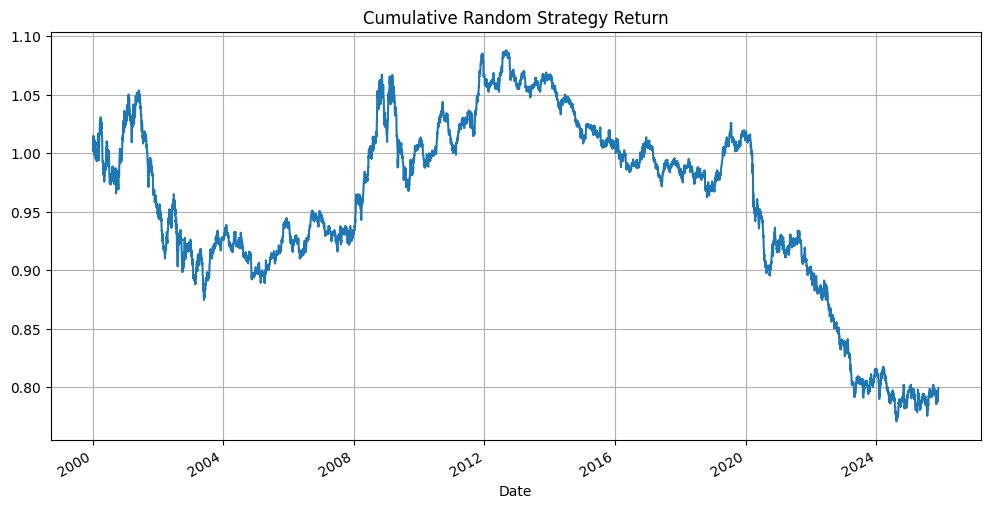

In [18]:
(random_daily_returns.cumsum()*1e-4+1).plot(figsize=(12,6), title='Cumulative Random Strategy Return', grid=True)

In [19]:
random_daily_returns.mean()/random_daily_returns.std()*np.sqrt(252)

np.float64(-0.20084115820711002)

## Momentum Strategies

In [20]:
df = pd.read_parquet('df_base.pq')

### Simple Momentum Strategy

In [21]:
def compute_signal(x):
    if x.notna().sum() == 0:
        return pd.Series([np.nan]*len(x), index=x.index)
    ranks = x.rank(method='first')
    binned = pd.cut(ranks, bins=10, labels=False, include_lowest=True)
    signal = binned.map(lambda y: -1 if y == 0 else (1 if y == 9 else 0))
    return signal

In [22]:
df['momentum_signal'] = df.groupby('Date')['close_1d_ret_lag1'].transform(compute_signal)

In [23]:
momentum_daily_returns = df.groupby('Date').apply(
    lambda x: (x['momentum_signal'] * x['close_1d_ret']).sum()/70
)*1e-4

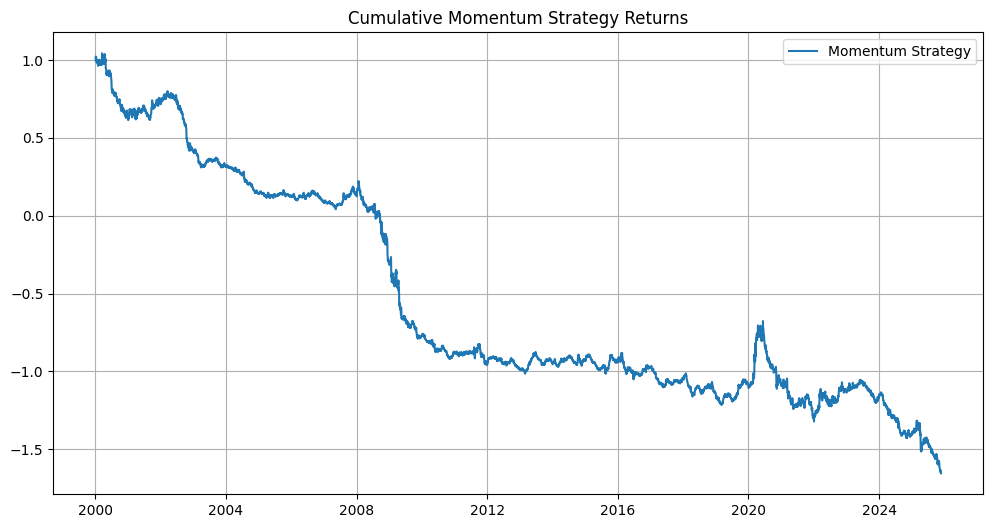

In [24]:
plt.figure(figsize=(12, 6))
plt.plot(momentum_daily_returns.cumsum() + 1, label='Momentum Strategy')
plt.title('Cumulative Momentum Strategy Returns')
plt.grid(True)
plt.legend()
plt.show()

In [25]:
momentum_daily_returns.mean()/momentum_daily_returns.std()*np.sqrt(252)

np.float64(-0.7791753241611957)

In [26]:
monthly_returns = np.log(data['Close'].resample('MS').first()).diff().iloc[1:]

In [27]:
monthly_momentum_rank = monthly_returns.rank(method='first', axis=1)
monthly_momentum_bin = monthly_momentum_rank.apply(lambda row: pd.cut(row, bins=10, labels=False, include_lowest=True), axis=1)
monthly_momentum_signal = monthly_momentum_bin.map(lambda y: -1 if y == 0 else (1 if y == 9 else 0)).shift()

In [28]:
monthly_momentum_returns = (monthly_momentum_signal*monthly_returns).sum(1)/70

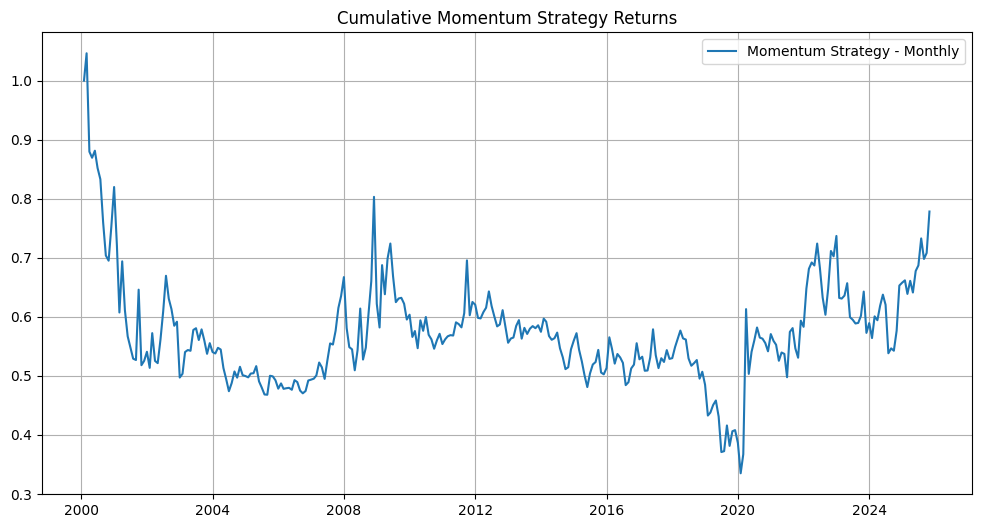

In [29]:
plt.figure(figsize=(12, 6))
plt.plot(monthly_momentum_returns.cumsum() + 1, label='Momentum Strategy - Monthly')
plt.title('Cumulative Momentum Strategy Returns')
plt.grid(True)
plt.legend()
plt.show()

In [30]:
monthly_momentum_returns.mean()/monthly_momentum_returns.std()

np.float64(-0.017697747042569986)

### MACD Vol adjusted Strategy

In [78]:
short_span_list = [8, 16, 32]
long_span_list = [24, 48, 96]

In [79]:
for i, (short_span, long_span) in enumerate(zip(short_span_list, long_span_list)):
    macd_adj_series = (df.groupby('Ticker')['close_1d_ret'].ewm(span=short_span, adjust=False).mean() - df.groupby('Ticker')['close_1d_ret'].ewm(span=long_span, adjust=False).mean())/df.groupby('Ticker')['close_1d_ret'].rolling(63).std()
    macd_adj_series.name = f'macd_adj_{i+1}'
    df = df.merge(macd_adj_series, on=['Date', 'Ticker'], how='right')
    df[f'macd_adj_{i+1}'] /= df[f'macd_adj_{i+1}'].rolling(252).std()

In [80]:
def phi_baz(x):
    return x / np.sqrt(1 + x**2)

In [81]:
df['macd_baz_signal'] = df[['macd_adj_1', 'macd_adj_2', 'macd_adj_3']].apply(phi_baz).sum(1).replace(0, np.nan)
df['macd_baz_signal'] = df.groupby('Date')['macd_baz_signal'].transform(compute_signal)

In [82]:
df['macd_tanh_signal'] = df[['macd_adj_1', 'macd_adj_2', 'macd_adj_3']].apply(np.tanh).sum(1).replace(0, np.nan)
df['macd_tanh_signal']  = df.groupby('Date')['macd_tanh_signal'].transform(compute_signal)

In [83]:
df['macd_baz_signal'] = df.groupby('Ticker')['macd_baz_signal'].shift()
df['macd_tanh_signal'] = df.groupby('Ticker')['macd_tanh_signal'].shift()

In [84]:
macd_daily_returns = df.groupby('Date').apply(
    lambda x: pd.Series({
        'baz': (x['macd_baz_signal'] * x['close_1d_ret']).sum()/70,
        'tanh': (x['macd_tanh_signal'] * x['close_1d_ret']).sum()/70
    })
)*1e-4

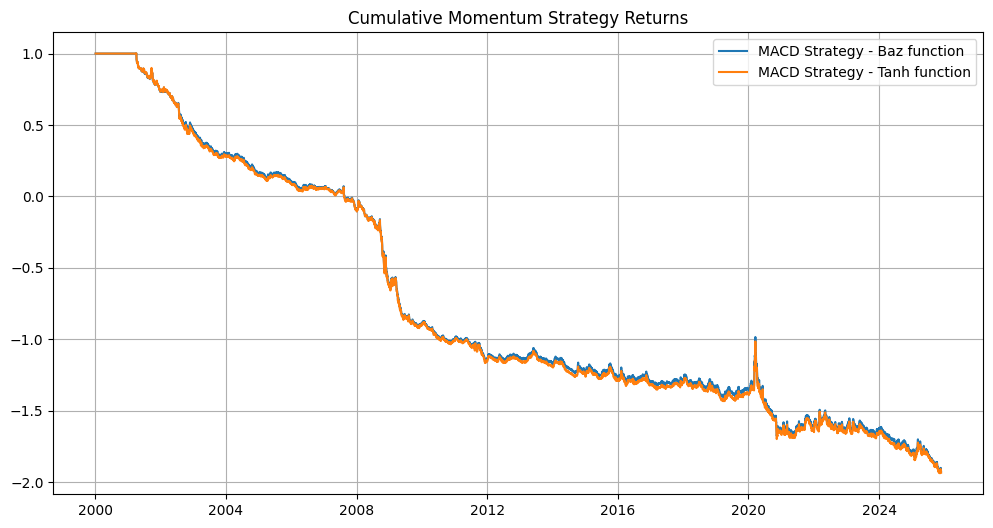

In [85]:
plt.figure(figsize=(12, 6))
plt.plot(macd_daily_returns['baz'].cumsum() + 1, label='MACD Strategy - Baz function')
plt.plot(macd_daily_returns['tanh'].cumsum() + 1, label='MACD Strategy - Tanh function')

plt.title('Cumulative Momentum Strategy Returns')
plt.grid(True)
plt.legend()
plt.show()

In [86]:
macd_daily_returns.mean()/macd_daily_returns.std()*np.sqrt(252)

baz    -1.060794
tanh   -1.064826
dtype: float64

# Regress-then-rank Strategies 

In [31]:
df = pd.read_parquet('df_base.pq')

## Linear Regression

### Feature factory

In [32]:
linear_features

['close_1d_ret_lag1',
 'close_1d_ret_hedged_lag1',
 'open_close_ret',
 'open_close_ret_hedged',
 'close_open_ret',
 'close_open_ret_hedged',
 'high_low_ret',
 'high_low_ret_hedged',
 'body_ratio']

In [33]:
all_linear_features = copy.deepcopy(linear_features)

close_1d_ret_lag1


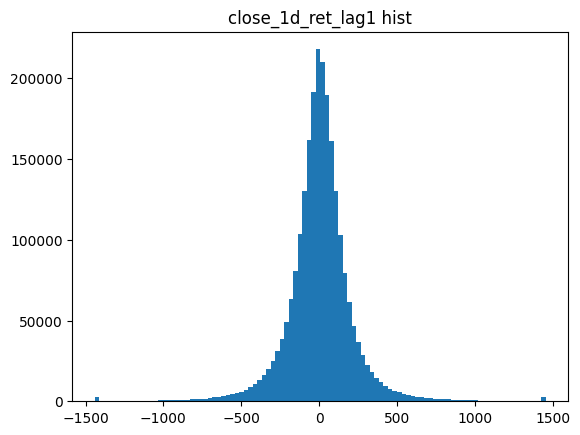

close_1d_ret_hedged_lag1


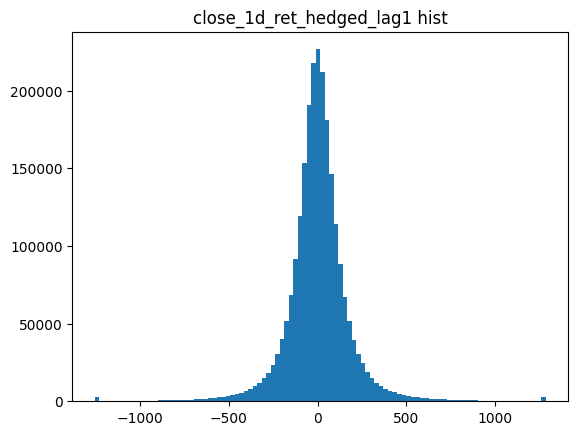

open_close_ret


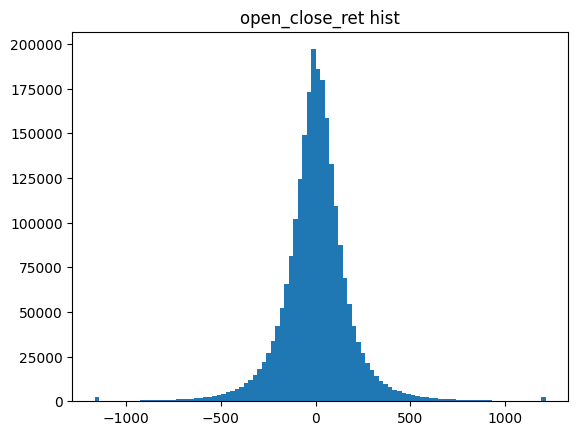

open_close_ret_hedged


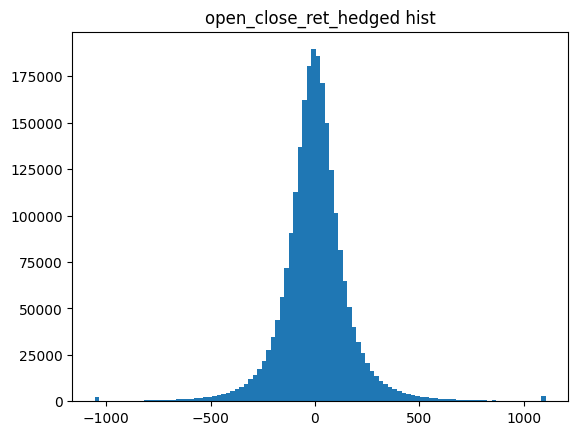

close_open_ret


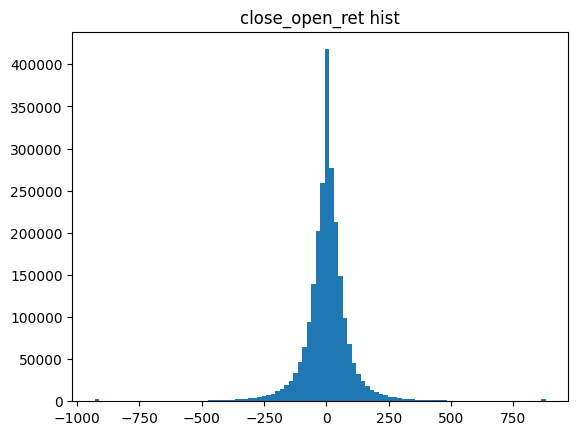

close_open_ret_hedged


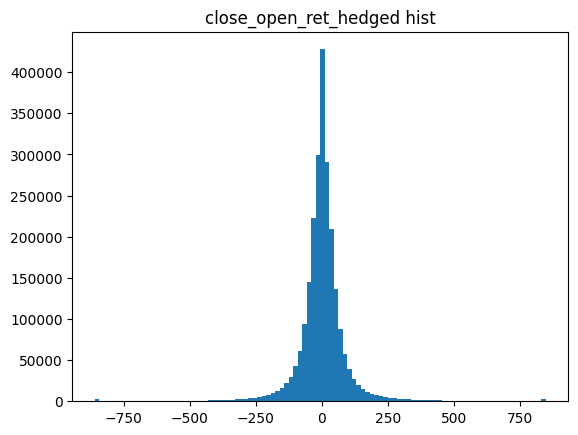

high_low_ret


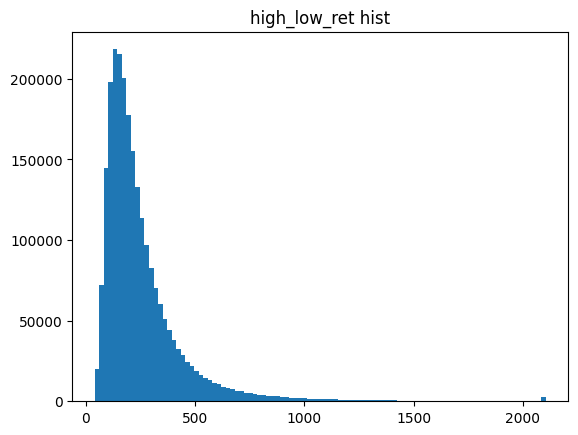

high_low_ret_hedged


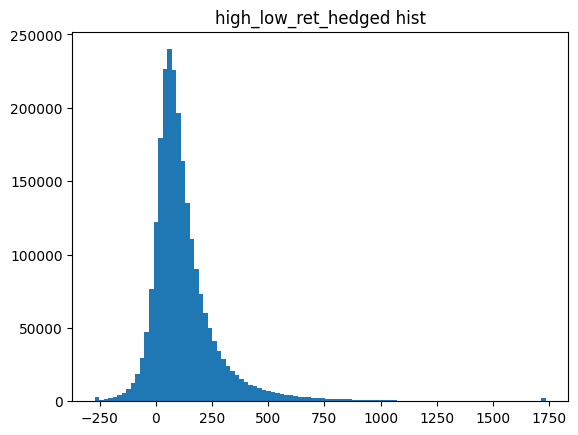

body_ratio


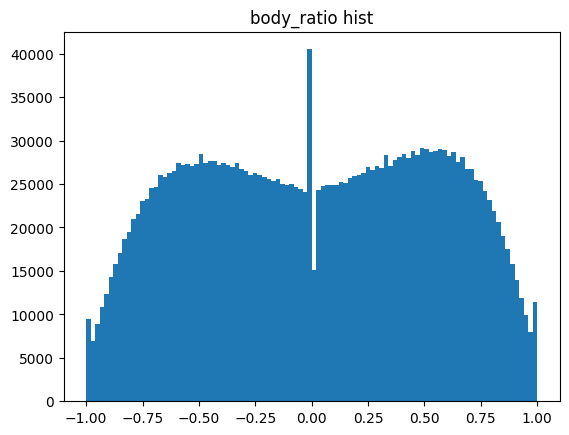

In [61]:
for feature in linear_features:
    print(feature)
    plt.hist(pd.Series(winsorize(df[feature], limits=0.001)).dropna(), bins=100)
    plt.title(f'{feature} hist')
    plt.show()

In [34]:
for feature in tqdm(linear_features):
    for h in [3, 5, 10, 15, 20, 30, 60, 80]:
        df[f'avg_{feature}_{h}d'] = df.groupby('Ticker')[feature].transform(lambda x: x.rolling(h).mean())
        df[f'zscore_{feature}_{h}d'] = (df[feature]-df[f'avg_{feature}_{h}d'])/df.groupby('Ticker')[feature].transform(lambda x: x.rolling(h).std())
        df[f'sharpe_{feature}_{h}d'] = df[f'avg_{feature}_{h}d']/df.groupby('Ticker')[feature].transform(lambda x: x.rolling(h).std())
        all_linear_features.append(f'avg_{feature}_{h}d')
        all_linear_features.append(f'zscore_{feature}_{h}d')
        all_linear_features.append(f'sharpe_{feature}_{h}d')

  0%|          | 0/9 [00:00<?, ?it/s]

 44%|████▍     | 4/9 [02:39<03:27, 41.55s/it]/tmp/ipykernel_2036/3641886625.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'sharpe_{feature}_{h}d'] = df[f'avg_{feature}_{h}d']/df.groupby('Ticker')[feature].transform(lambda x: x.rolling(h).std())
/tmp/ipykernel_2036/3641886625.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'avg_{feature}_{h}d'] = df.groupby('Ticker')[feature].transform(lambda x: x.rolling(h).mean())
/tmp/ipykernel_2036/3641886625.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is

In [36]:
# df.to_parquet('data/df_all_features.pq')

### Article features

In [37]:
article_features = []

feature = 'close_1d_ret'
for h in [3, 5, 20, 60]:
    df[f'avg_{feature}_{h}d'] = df.groupby('Ticker')[feature].transform(lambda x: x.rolling(h).mean())
    df[f'avg_{feature}_{h}d'] = df.groupby('Ticker')[f'avg_{feature}_{h}d'].shift()
    df[f'vol_{h}d'] = df.groupby('Ticker')[feature].transform(lambda x: x.rolling(h).std())*np.sqrt(252)
    df[f'vol_{h}d'] = df.groupby('Ticker')[f'vol_{h}d'].shift()
    df[f'avg_normalised_{feature}_{h}d'] = df[f'avg_{feature}_{h}d']/df[f'vol_{h}d']
    article_features.append(f'avg_{feature}_{h}d')
    article_features.append(f'avg_normalised_{feature}_{h}d')

/tmp/ipykernel_2036/1383597058.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'avg_{feature}_{h}d'] = df.groupby('Ticker')[feature].transform(lambda x: x.rolling(h).mean())
/tmp/ipykernel_2036/1383597058.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'vol_{h}d'] = df.groupby('Ticker')[feature].transform(lambda x: x.rolling(h).std())*np.sqrt(252)
/tmp/ipykernel_2036/1383597058.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

#### Test for MACD Features

In [41]:
test_df = df[['Ticker']]
short_span_list = [8, 16, 32]
long_span_list = [24, 48, 96]
for window in tqdm([21, 63, 126, 252]):
    for i, (short_span, long_span) in enumerate(zip(short_span_list, long_span_list)):
        macd_adj_series = (df.groupby('Ticker')['close_1d_ret'].ewm(span=short_span, adjust=False).mean() - df.groupby('Ticker')['close_1d_ret'].ewm(span=long_span, adjust=False).mean())/df.groupby('Ticker')['close_1d_ret'].rolling(63).std()
        macd_adj_series.name = f'macd_adj_first_{window}_{i+1}'
        test_df = test_df.merge(macd_adj_series, on=['Date', 'Ticker'], how='right')
        test_df[f'macd_adj_first_{window}_{i+1}'] /= test_df[f'macd_adj_first_{window}_{i+1}'].rolling(window).std()

for window in tqdm([21, 63, 126, 252]):
    for i, (short_span, long_span) in enumerate(zip(short_span_list, long_span_list)):
        macd_adj_series = (df.groupby('Ticker')['close_1d_ret'].ewm(span=short_span, adjust=False).mean() - df.groupby('Ticker')['close_1d_ret'].ewm(span=long_span, adjust=False).mean())/df.groupby('Ticker')['close_1d_ret'].rolling(window).std()
        macd_adj_series.name = f'macd_adj_second_{window}_{i+1}'
        test_df = test_df.merge(macd_adj_series, on=['Date', 'Ticker'], how='right')
        test_df[f'macd_adj_second_{window}_{i+1}'] /= test_df[f'macd_adj_second_{window}_{i+1}'].rolling(252).std()

100%|██████████| 4/4 [00:32<00:00,  8.01s/it]


In [42]:
test_df.drop(columns='Ticker').corr()

,macd_adj_first_21_1,macd_adj_first_21_2,macd_adj_first_21_3,macd_adj_first_63_1,macd_adj_first_63_2,macd_adj_first_63_3,macd_adj_first_126_1,macd_adj_first_126_2,macd_adj_first_126_3,macd_adj_first_252_1,...,macd_adj_second_21_3,macd_adj_second_63_1,macd_adj_second_63_2,macd_adj_second_63_3,macd_adj_second_126_1,macd_adj_second_126_2,macd_adj_second_126_3,macd_adj_second_252_1,macd_adj_second_252_2,macd_adj_second_252_3
macd_adj_first_21_1,1.000000,0.862448,0.544222,0.960550,0.848635,0.596267,0.951997,0.837783,0.585889,0.949976,...,0.579770,0.949976,0.833573,0.575704,0.928337,0.814925,0.564625,0.911329,0.800540,0.555165
macd_adj_first_21_2,0.862448,1.000000,0.822700,0.821791,0.942424,0.837304,0.814090,0.934597,0.838068,0.812094,...,0.852135,0.812094,0.933049,0.834615,0.793941,0.912427,0.818102,0.779571,0.896405,0.804267
macd_adj_first_21_3,0.544222,0.822700,1.000000,0.526924,0.768294,0.915679,0.523233,0.761163,0.907902,0.521071,...,0.937931,0.521071,0.759594,0.910464,0.509796,0.743146,0.890182,0.500556,0.730411,0.875356
macd_adj_first_63_1,0.960550,0.821791,0.526924,1.000000,0.878665,0.612981,0.987832,0.862525,0.598377,0.984285,...,0.560497,0.984285,0.855684,0.585666,0.953605,0.829396,0.569586,0.934678,0.813598,0.559381
macd_adj_first_63_2,0.848635,0.942424,0.768294,0.878665,1.000000,0.873316,0.868632,0.984113,0.863105,0.865467,...,0.826703,0.865467,0.978482,0.853231,0.839060,0.948841,0.829472,0.822363,0.930568,0.814193
macd_adj_first_63_3,0.596267,0.837304,0.915679,0.612981,0.873316,1.000000,0.608304,0.861981,0.974059,0.605875,...,0.945715,0.605875,0.857235,0.966571,0.587883,0.831937,0.937928,0.576041,0.815984,0.920777
macd_adj_first_126_1,0.951997,0.814090,0.523233,0.987832,0.868632,0.608304,1.000000,0.874801,0.606877,0.994757,...,0.563234,0.994757,0.866435,0.592892,0.977363,0.851635,0.584757,0.953403,0.831473,0.571655
macd_adj_first_126_2,0.837783,0.934597,0.761163,0.862525,0.984113,0.861981,0.874801,1.000000,0.879208,0.870312,...,0.834585,0.870312,0.992613,0.866931,0.855273,0.975333,0.853965,0.834300,0.952048,0.834405
macd_adj_first_126_3,0.585889,0.838068,0.907902,0.598377,0.863105,0.974059,0.606877,0.879208,1.000000,0.603716,...,0.960619,0.603716,0.873339,0.988161,0.593846,0.858495,0.971385,0.579189,0.838055,0.949056
macd_adj_first_252_1,0.949976,0.812094,0.521071,0.984285,0.865467,0.605875,0.994757,0.870312,0.603716,1.000000,...,0.564741,1.000000,0.872006,0.596576,0.988100,0.861958,0.591770,0.970893,0.847576,0.582688


#### End

In [38]:
short_span_list = [8, 16, 32]
long_span_list = [24, 48, 96]

for i, (short_span, long_span) in enumerate(zip(short_span_list, long_span_list)):
    macd_adj_series = (df.groupby('Ticker')['close_1d_ret'].ewm(span=short_span, adjust=False).mean() - df.groupby('Ticker')['close_1d_ret'].ewm(span=long_span, adjust=False).mean())/df.groupby('Ticker')['close_1d_ret'].rolling(63).std()
    macd_adj_series.name = f'macd_adj_{i+1}'
    df = df.merge(macd_adj_series, on=['Date', 'Ticker'], how='right')
    df[f'macd_adj_{i+1}'] /= df[f'macd_adj_{i+1}'].rolling(252).std()
    df[f'macd_adj_{i+1}'] = df.groupby('Ticker')[f'macd_adj_{i+1}'].shift()
    article_features.append(f'macd_adj_{i+1}')

In [39]:
def phi_baz(x):
    return x / np.sqrt(1 + x**2)

In [40]:
df['macd_baz_signal'] = df[['macd_adj_1', 'macd_adj_2', 'macd_adj_3']].apply(phi_baz).sum(1).replace(0, np.nan)
article_features.append('macd_baz_signal')

In [41]:
df[article_features].corr()

,avg_close_1d_ret_3d,avg_normalised_close_1d_ret_3d,avg_close_1d_ret_5d,avg_normalised_close_1d_ret_5d,avg_close_1d_ret_20d,avg_normalised_close_1d_ret_20d,avg_close_1d_ret_60d,avg_normalised_close_1d_ret_60d,macd_adj_1,macd_adj_2,macd_adj_3,macd_baz_signal
avg_close_1d_ret_3d,1.000000,0.097115,0.765656,0.546004,0.383189,0.318450,0.212881,0.191793,0.740824,0.668074,0.539485,0.663433
avg_normalised_close_1d_ret_3d,0.097115,1.000000,0.074309,0.110595,0.036978,0.046595,0.022667,0.028013,0.097999,0.087659,0.070357,0.093975
avg_close_1d_ret_5d,0.765656,0.074309,1.000000,0.712391,0.494516,0.408203,0.274486,0.246013,0.695702,0.729411,0.636678,0.712371
avg_normalised_close_1d_ret_5d,0.546004,0.110595,0.712391,1.000000,0.348596,0.436142,0.205807,0.254376,0.689436,0.719814,0.626016,0.749169
avg_close_1d_ret_20d,0.383189,0.036978,0.494516,0.348596,1.000000,0.813239,0.556439,0.480881,0.185926,0.464985,0.679632,0.465326
avg_normalised_close_1d_ret_20d,0.318450,0.046595,0.408203,0.436142,0.813239,1.000000,0.456939,0.554249,0.213163,0.530702,0.776361,0.546762
avg_close_1d_ret_60d,0.212881,0.022667,0.274486,0.205807,0.556439,0.456939,1.000000,0.842618,0.024266,0.083131,0.285011,0.118326
avg_normalised_close_1d_ret_60d,0.191793,0.028013,0.246013,0.254376,0.480881,0.554249,0.842618,1.000000,0.035492,0.106928,0.343599,0.151773
macd_adj_1,0.740824,0.097999,0.695702,0.689436,0.185926,0.213163,0.024266,0.035492,1.000000,0.871979,0.596383,0.842681
macd_adj_2,0.668074,0.087659,0.729411,0.719814,0.464985,0.530702,0.083131,0.106928,0.871979,1.000000,0.875284,0.953198


In [42]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

In [43]:
class Winsorizer(BaseEstimator, TransformerMixin):
    """
    Transformateur pour winsoriser les features.
    Les limites sont apprises sur le train set et appliquées au test set.
    """
    def __init__(self, lower=0.01, upper=0.01):
        self.lower = lower
        self.upper = upper
        self.lower_bounds_ = None
        self.upper_bounds_ = None
    
    def fit(self, X, y=None):
        """Apprend les limites de winsorisation sur X"""
        if isinstance(X, pd.DataFrame):
            self.lower_bounds_ = X.quantile(self.lower)
            self.upper_bounds_ = X.quantile(1 - self.upper)
            self.feature_names_ = X.columns
        else:
            # Pour numpy array
            self.lower_bounds_ = np.percentile(X, self.lower * 100, axis=0)
            self.upper_bounds_ = np.percentile(X, (1 - self.upper) * 100, axis=0)
        
        return self
    
    def transform(self, X):
        """Applique la winsorisation avec les limites apprises"""
        if self.lower_bounds_ is None or self.upper_bounds_ is None:
            raise ValueError("Winsorizer must be fitted before transform")
        
        X_copy = X.copy()
        
        if isinstance(X, pd.DataFrame):
            for col in X.columns:
                X_copy[col] = np.clip(X_copy[col], 
                                     self.lower_bounds_[col], 
                                     self.upper_bounds_[col])
        else:
            # Pour numpy array
            X_copy = np.clip(X_copy, self.lower_bounds_, self.upper_bounds_)
        
        return X_copy

In [44]:
X = df[article_features + ["close_1d_ret"]].replace([-np.inf, np.inf], np.nan).dropna()[article_features]
y = df[article_features + ["close_1d_ret"]].replace([-np.inf, np.inf], np.nan).dropna()["close_1d_ret"]

split_date = X.index.unique()[int(X.index.nunique()*0.8)]

X_train = X.loc[X.index<split_date]
X_test = X.loc[X.index>=split_date]
y_train = y.loc[y.index<split_date]
y_test = y.loc[y.index>=split_date]

In [45]:
ols_baseline = Pipeline([
    ('winsorizer', Winsorizer(lower=0.001, upper=0.001)),
    ('reg', LinearRegression(fit_intercept=False))
])

In [46]:
ols_baseline.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('winsorizer', ...), ('reg', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,lower,0.001
,upper,0.001
,"fit_intercept fit_intercept: bool, default=TrueWhether to calculate the intercept for this model. If setto False, no intercept will be used in calculations(i.e. data is expected to be centered).",False
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True
,"tol tol: float, default=1e-6The precision of the solution (`coef_`) is determined by `tol` whichspecifies a different convergence criterion for the `lsqr` solver.`tol` is set as `atol` and `btol` of :func:`scipy.sparse.linalg.lsqr` whenfitting on sparse training data. This parameter has no effect when fittingon dense data... versionadded:: 1.7",1e-06
,"n_jobs n_jobs: int, default=NoneThe number of jobs to use for the computation. This will only providespeedup in case of sufficiently large problems, that is if firstly`n_targets > 1` and secondly `X` is sparse or if `positive` is setto `True`. ``None`` means 1 unless in a:obj:`joblib.parallel_backend` context. ``-1`` means using allprocessors. See :term:`Glossary ` for more details.",None
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive. Thisoption is only supported for dense arrays.For a comparison between a linear regression model with positive constraintson the regression coefficients and a linear regression without such constraints,see :ref:`sphx_glr_auto_examples_linear_model_plot_nnls.py`... versionadded:: 0.24",False


In [47]:
X_train.columns

Index(['avg_close_1d_ret_3d', 'avg_normalised_close_1d_ret_3d',
       'avg_close_1d_ret_5d', 'avg_normalised_close_1d_ret_5d',
       'avg_close_1d_ret_20d', 'avg_normalised_close_1d_ret_20d',
       'avg_close_1d_ret_60d', 'avg_normalised_close_1d_ret_60d', 'macd_adj_1',
       'macd_adj_2', 'macd_adj_3', 'macd_baz_signal'],
      dtype='object')

In [48]:
ols_baseline.named_steps['reg'].coef_

array([ 1.32025187e-02, -1.27817318e+01, -7.15245713e-02, -3.28702126e+01,
        5.09893345e-02, -6.10487876e+01, -3.18461261e-01,  1.12512359e+03,
       -7.65770769e+00,  5.97634031e+00, -9.58249585e+00,  6.52600903e+00])

In [49]:
y_pred = ols_baseline.predict(X_test)

In [50]:
df_test = df[df.index>=split_date][article_features + ["Ticker", "close_1d_ret"]].replace([-np.inf, np.inf], np.nan).dropna()[["Ticker", "close_1d_ret"]]
# df_test = df[df.index>=split_date].replace([-np.inf, np.inf], np.nan).dropna()

In [51]:
df_test['y_pred'] = y_pred

In [52]:
def compute_signal(x):
    if x.notna().sum() == 0:
        return pd.Series([np.nan]*len(x), index=x.index)
    ranks = x.rank(method='first')
    binned = pd.cut(ranks, bins=10, labels=False, include_lowest=True)
    signal = binned.map(lambda y: -1 if y == 0 else (1 if y == 9 else 0))
    return signal

In [53]:
df_test['ols_signal'] = df_test.groupby('Date')['y_pred'].transform(compute_signal)

In [54]:
ols_daily_returns = df_test.groupby('Date').apply(lambda x: (x['ols_signal']*x['close_1d_ret']).sum()/70)

<Axes: title={'center': 'Cumulative Random Strategy Return'}, xlabel='Date'>

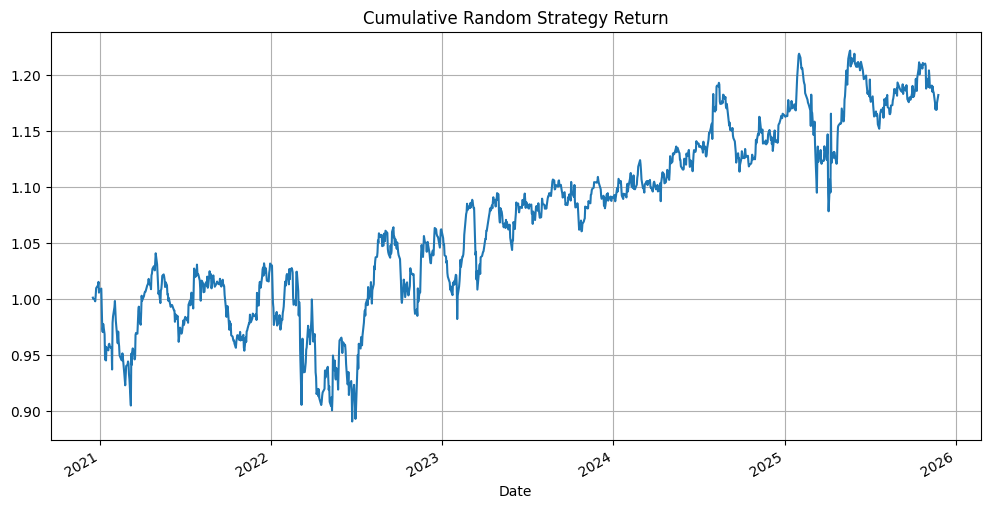

In [55]:
(ols_daily_returns.cumsum()*1e-4+1).plot(figsize=(12,6), title='Cumulative Random Strategy Return', grid=True)

In [56]:
ols_daily_returns.mean()/ols_daily_returns.std()

np.float64(0.016818249489745692)

### All features

In [57]:
X = df[all_linear_features + ["close_1d_ret"]].replace([-np.inf, np.inf], np.nan).dropna()[all_linear_features]
y = df[all_linear_features + ["close_1d_ret"]].replace([-np.inf, np.inf], np.nan).dropna()["close_1d_ret"]

split_date = X.index.unique()[int(X.index.nunique()*0.8)]

X_train = X.loc[X.index<split_date]
X_test = X.loc[X.index>=split_date]
y_train = y.loc[y.index<split_date]
y_test = y.loc[y.index>=split_date]

In [58]:
ols_baseline.fit(X_train, y_train)


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('winsorizer', ...), ('reg', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,lower,0.001
,upper,0.001
,"fit_intercept fit_intercept: bool, default=TrueWhether to calculate the intercept for this model. If setto False, no intercept will be used in calculations(i.e. data is expected to be centered).",False
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True
,"tol tol: float, default=1e-6The precision of the solution (`coef_`) is determined by `tol` whichspecifies a different convergence criterion for the `lsqr` solver.`tol` is set as `atol` and `btol` of :func:`scipy.sparse.linalg.lsqr` whenfitting on sparse training data. This parameter has no effect when fittingon dense data... versionadded:: 1.7",1e-06
,"n_jobs n_jobs: int, default=NoneThe number of jobs to use for the computation. This will only providespeedup in case of sufficiently large problems, that is if firstly`n_targets > 1` and secondly `X` is sparse or if `positive` is setto `True`. ``None`` means 1 unless in a:obj:`joblib.parallel_backend` context. ``-1`` means using allprocessors. See :term:`Glossary ` for more details.",None
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive. Thisoption is only supported for dense arrays.For a comparison between a linear regression model with positive constraintson the regression coefficients and a linear regression without such constraints,see :ref:`sphx_glr_auto_examples_linear_model_plot_nnls.py`... versionadded:: 0.24",False


In [59]:
y_pred = ols_baseline.predict(X_test)
df_test = df[df.index>=split_date][all_linear_features + ["Ticker", "close_1d_ret"]].replace([-np.inf, np.inf], np.nan).dropna()[["Ticker", "close_1d_ret"]]
df_test['y_pred'] = y_pred

In [60]:
df_test['ols_signal'] = df_test.groupby('Date')['y_pred'].transform(compute_signal)
ols_daily_returns = df_test.groupby('Date').apply(lambda x: (x['ols_signal']*x['close_1d_ret']).sum()/70)

<Axes: title={'center': 'Cumulative Random Strategy Return'}, xlabel='Date'>

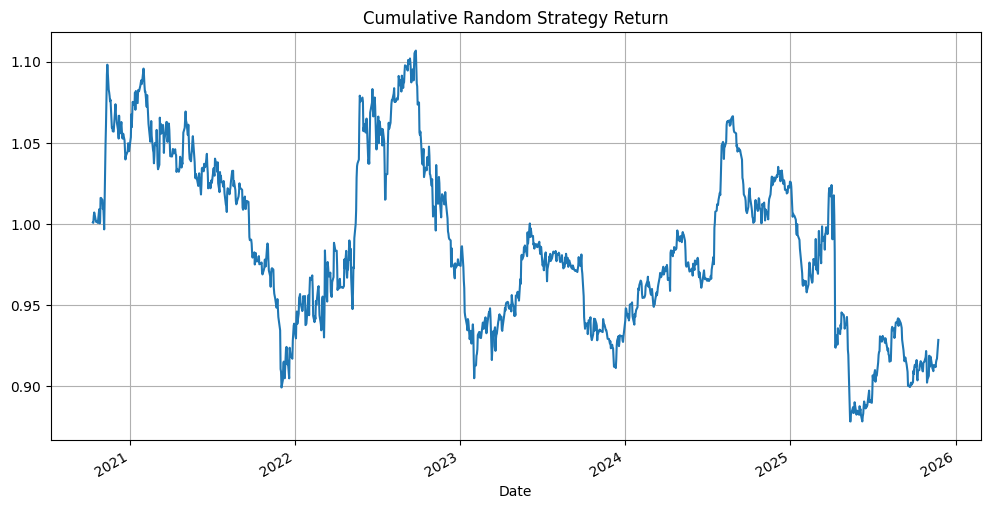

In [61]:
(ols_daily_returns.cumsum()*1e-4+1).plot(figsize=(12,6), title='Cumulative Random Strategy Return', grid=True)

In [62]:
ols_daily_returns.mean()/ols_daily_returns.std()

np.float64(-0.007964412848873555)

## Random Forest

In [63]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from scipy.stats import randint, uniform
import numpy as np

In [64]:
rf = RandomForestRegressor(random_state=42)

In [65]:
param_distributions = {
    'n_estimators': [200],
    'max_depth': [3, 5, 10, 20, 40],
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False],
    'max_samples': uniform(0.5, 0.5)
}

In [66]:
tscv = TimeSeriesSplit(n_splits=5)

In [67]:
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_distributions,
    n_iter=2,
    cv=tscv,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=2,
    random_state=42
)

In [ ]:
%%time
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


In [ ]:
print(f"Best parameters: {random_search.best_params_}")
print(f"Best CV score: {-random_search.best_score_:.4f}")

# Best model
best_rf = random_search.best_estimator_

# Make predictions on test set
y_pred = best_rf.predict(X_test)

# Evaluate performance
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Test MSE: {mse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test R²: {r2:.4f}")
